### GOAL

- Plot breakpoints recovery
- Plot the results for the mixtures. And compute the recovery rate



In [1]:
!python -m pip install pysam

### 1. Breakpoint recovery

Evaluate if the breakpoints which compose the amplicon can be recovered.

In [2]:
dict_amplicon_mapper = {"CHP212":{'1':"MYCN"},
                       "STA-NB-10DM":{'3':"MYCN"},
                       "TR14":{'4':"ODC1",
                               '7':"MYCN",
                               '8':"SMC6",
                               '9':"MDM2"}}
dict_ecDNA = {"CHP212":"../data/ecDNA_reconstruction/celllines/chp212/reconstruct.ecDNA.genes.bed",
              "TR14":"../data/ecDNA_reconstruction/celllines/tr14/reconstruct.ecDNA.genes.bed",
              "STA-NB-10DM":"../data/ecDNA_reconstruction/celllines/sta-nb-10-dm/reconstruct.ecDNA.genes.bed"}


In [3]:
import numpy as np
import pandas as pd

def get_breakpoints(df_ecDNA):

    breakpoints = pd.DataFrame(columns=["#chr", "start", "strand", "gene"])
    circ_id = df_ecDNA["circ_id"].drop_duplicates().tolist()

    for c in circ_id:
        
        df_temp = df_ecDNA[df_ecDNA["circ_id"] == c]
        l = df_temp.shape[0]
        for i in range(0, l):
            row1 = df_temp.iloc[i, :]
            row2 = df_temp.iloc[(i + 1) % l, :]
        
            start1 = None
            start2 = None
            strand1 = None
            strand2 = None
            chr1 = None
            chr2 = None

            if row1["strand"] == "+" and row2["strand"] == "+":
                # DEL
                chr1 = row1["#chr"]
                start1 = row1["end"]
                strand1 = "+"
                
                chr2 = row2["#chr"]
                start2 = row2["start"]
                strand2 = "-"
            
            elif row1["strand"] == "+" and row2["strand"] == "-":
                
                chr1 = row1["#chr"]
                start1 = row1["end"]
                strand1 = "+"
                
                chr2 = row2["#chr"]
                start2 = row2["end"]
                strand2 = "+"
            
            elif row1["strand"] == "-" and row2["strand"] == "+":
                
                chr1 = row1["#chr"]
                start1 = row1["start"]
                strand1 = "-"
                
                chr2 = row2["#chr"]
                start2 = row2["start"]
                strand2 = "-"
                
            elif row1["strand"] == "-" and row2["strand"] == "-":
                # DUP
                chr1 = row1["#chr"]
                start1 = row1["start"]
                strand1 = "-"
                
                chr2 = row2["#chr"]
                start2 = row2["end"]
                strand2 = "+"

            breakpoints = breakpoints.append({
                "#chr": chr1,
                "start": start1,
                "strand": strand1,
                "gene": c}, ignore_index=True)
            
            breakpoints = breakpoints.append({
                "#chr": chr2,
                "start": start2,
                "strand": strand2,
                "gene": c}, ignore_index=True)

    return breakpoints

In [4]:
from pysam import VariantFile
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

file="../data/ecDNA_mixtures/files_merged.vcf"
bcf_in = VariantFile(file)  # auto-detect input format
all_samples = list(bcf_in.header.samples)

df_all = pd.DataFrame(columns=["#chr","start","strand","gene","sample"])
df_breakpoints_status = pd.DataFrame(columns=["cellline","dilution","found","chr","breakpoint","sample"])

def extract_sample(supp_vec_temp, sample_temp, all_samples_temp, chr, breakpoint, gene):
    found_variant = list(map(int, list(supp_vec_temp)))
    data1 = pd.DataFrame(columns=["cellline","dilution","found","chr","breakpoint","sample", "gene"])
    
    if np.sum(np.array(found_variant)) >= 3:
        for i, s in enumerate(all_samples_temp):
            if sample_temp in s:
                _, stemp = s.split("/")
                s1, dil1, s2, dil2, _ = stemp.split("_")
                if s1 == sample_temp:
                    row1 = pd.Series([s1, dil1, found_variant[i], chr, breakpoint, stemp, gene], index=data1.columns)
                    data1 = data1.append(row1,ignore_index=True)
                else:
                    row1 = pd.Series([s2, dil2, found_variant[i], chr, breakpoint, stemp, gene], index=data1.columns)
                    data1 = data1.append(row1,ignore_index=True)
        return data1

# for every sample
for sample in dict_ecDNA:
    df_fragments = pd.read_csv(dict_ecDNA[sample], header=0, sep="\t")
    df_breakpoints = get_breakpoints(df_fragments)
    df_breakpoints["sample"] = sample
    df_all = df_all.append(df_breakpoints, ignore_index=True)
    # df_breakpoints = pd.DataFrame(np.concatenate([df_breakpoints[["#chr","start","circ_id"]].values,
    #                                                    df_breakpoints[["#chr","end","circ_id"]].values]),
    #                                    columns=["chr","pos","gene"])
    # df_breakpoints["sample"] = sample
    # df_all = df_all.append(df_breakpoints, ignore_index=True)
                      
# for every breakpoint
for i in range(0, df_all.shape[0]):
    chr, br, strand, gene, sample = df_all.iloc[i,:].tolist()

    for rec in bcf_in.fetch():
        chr1 = rec.contig
        pos1 = rec.pos
        chr2 = rec.info["CHR2"]
        pos2 = rec.stop
        supp_vec = rec.info["SUPP_VEC"]
        # check if any of the breakpoints match the vcf entry
        if chr == chr1 and ((int(br) - 50) < int(pos1) < (int(br) + 50)):
       
            df_var = extract_sample(supp_vec, sample, all_samples, chr, br, gene)
            df_breakpoints_status = df_breakpoints_status.append(df_var, ignore_index=True)

        if chr == chr2 and ((int(br) - 50) < int(pos2) < (int(br) + 50)):
            
            df_var = extract_sample(supp_vec, sample, all_samples, chr, br, gene)
            df_breakpoints_status = df_breakpoints_status.append(df_var, ignore_index=True)

[W::vcf_parse_info] INFO/END=148110 is smaller than POS at GL000009.2:200883


In [5]:
df_all.groupby(["gene","sample"]).count()

#chr  start  strand
gene sample                          
MDM2 TR14            2      2       2
MYCN CHP212         10     10      10
     STA-NB-10DM    14     14      14
     TR14            8      8       8
ODC1 TR14            4      4       4
SMC6 TR14            4      4       4

In [6]:
df_breakpoints_status = df_breakpoints_status.drop_duplicates()
df_breakpoints_status.head()

,cellline,dilution,found,chr,breakpoint,sample,gene
0,CHP212,1.00,1,chr2,11785250,CHP212_1.00_STA-NB-10DM_0.10_hg38.bam,MYCN
1,CHP212,1.00,1,chr2,11785250,CHP212_1.00_STA-NB-10DM_0.25_hg38.bam,MYCN
2,CHP212,1.00,1,chr2,11785250,CHP212_1.00_STA-NB-10DM_0.50_hg38.bam,MYCN
3,CHP212,1.00,1,chr2,11785250,CHP212_1.00_STA-NB-10DM_0.75_hg38.bam,MYCN
4,CHP212,1.00,1,chr2,11785250,CHP212_1.00_STA-NB-10DM_0.90_hg38.bam,MYCN


In [7]:
%load_ext rpy2.ipython

df_plot = df_breakpoints_status[["dilution","found","gene","cellline"]].groupby(["dilution","gene","cellline"]).agg({'found':['sum', 'count']}). reset_index()
df_plot.columns = ["dilution","gene","cellline", "sum", "count"]
df_plot["perc"] = df_plot.apply(lambda x: x["sum"]/x["count"], axis=1)

In [8]:
df_plot

,dilution,gene,cellline,sum,count,perc
0,0.10,MDM2,TR14,4,4,1.000000
1,0.10,MYCN,CHP212,20,20,1.000000
2,0.10,MYCN,STA-NB-10DM,28,32,0.875000
3,0.10,MYCN,TR14,16,24,0.666667
4,0.10,ODC1,TR14,4,8,0.500000
5,0.10,SMC6,TR14,0,8,0.000000
6,0.25,MDM2,TR14,4,4,1.000000
7,0.25,MYCN,CHP212,20,20,1.000000
8,0.25,MYCN,STA-NB-10DM,28,28,1.000000
9,0.25,MYCN,TR14,16,24,0.666667


In [9]:
import numpy as np
print("Recall = TP / (TP+FN)", np.sum(df_plot["sum"].tolist()) / np.sum(df_plot["count"].tolist()))

Recall = TP / (TP+FN) 0.9373072970195272


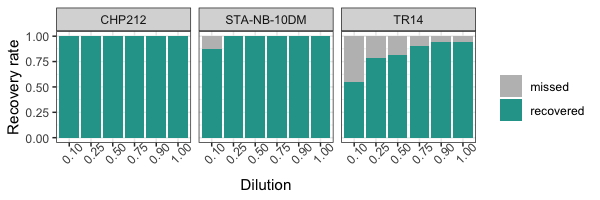

In [10]:
%%R -i df_breakpoints_status -w 6 -h 2 --units in -r 100

library(ggplot2)

p1 <- ggplot(df_breakpoints_status, aes(x = factor(dilution), fill=factor(found))) +
geom_bar(position = "fill") + 
scale_fill_manual("", values = c("0" = "gray", "1" = "#26a299"), labels = c("missed","recovered")) +
labs(y = "Recovery rate", x = "Dilution") + 
facet_wrap(~ cellline) + 
theme_bw() + 
theme(axis.text.x = element_text(angle = 45))

pdf("../data/ecDNA_mixtures/breakpoints_recovery.pdf")
print(p1)
dev.off()

png("../data/ecDNA_mixtures/breakpoints_recovery.png",width=500, height=300, res=100)
print(p1)
dev.off()

p1    

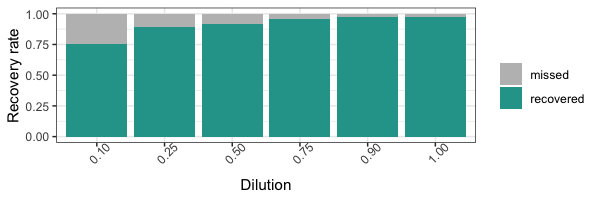

In [11]:
%%R -i df_breakpoints_status -w 6 -h 2 --units in -r 100

library(ggplot2)

p1 <- ggplot(df_breakpoints_status, aes(x = factor(dilution), fill=factor(found))) +
geom_bar(position = "fill") + 
scale_fill_manual("", values = c("0" = "gray", "1" = "#26a299"), labels = c("missed","recovered")) +
labs(y = "Recovery rate", x = "Dilution") + 
theme_bw() + 
theme(axis.text.x = element_text(angle = 45))

pdf("../data/ecDNA_mixtures/breakpoints_recovery_merged.pdf")
print(p1)
dev.off()

png("../data/ecDNA_mixtures/breakpoints_recovery_merged.png",width=500, height=300, res=100)
print(p1)
dev.off()

p1   